<a href="https://colab.research.google.com/github/astrrr/Image-Processing-Lab/blob/main/Activity6_imageprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 6.1 Data Preparation (5.1-5.2)

 5.1 Data Preparation



*   List all filename in face image path



In [45]:
filenames= glob.glob ('/content/drive/MyDrive/face_dataset/lfw/*/*')



*   # Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)




In [46]:
im_arr = []
for i in range(500):
  img = image.load_img(filenames[i],target_size=(90,90,3),interpolation='nearest')
  
  #convert img to arr
  img = image.img_to_array(img)
  
  #normalizeed color img
  img = img/255

  im_arr.append(img)



*   convert to numpy array




In [47]:
all_imgs = np.array(im_arr)

In [48]:
all_imgs.shape

(500, 90, 90, 3)

* split data into train and validation data

In [49]:
train_x, test_x = train_test_split(all_imgs, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

5.2 ADD NOISE



*   Add Noise




In [50]:
#noise_factor = scalar between 0 -1 ลองอย่ํางน้อย 2 ค่ํา
noise_factor = 0.5



*   กำหนด noise parameter




In [51]:
noise_dist = 'normal'
Nmean = 0
Nstd = 1

In [52]:
# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=(90,90,3)))
x_val_noisy = val_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=(90,90,3)))
x_test_noisy = test_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=(90,90,3)))

plot noise picture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


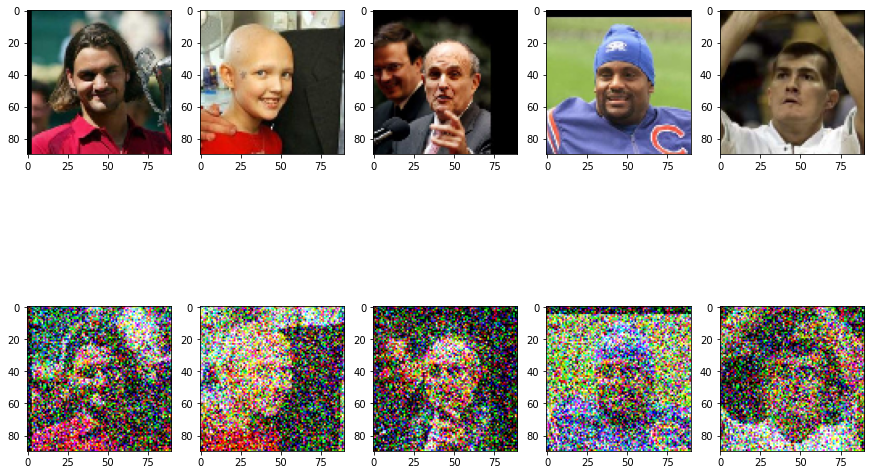

In [53]:
fig = plt.figure(figsize=(15,10)) #figsize=(5,10)

fig.add_subplot(2,5,1)
plt.imshow(test_x[0])

fig.add_subplot(2,5,2)
plt.imshow(test_x[1])

fig.add_subplot(2,5,3)
plt.imshow(test_x[2])

fig.add_subplot(2,5,4)
plt.imshow(test_x[3])

fig.add_subplot(2,5,5)
plt.imshow(test_x[4])

fig.add_subplot(2,5,6)
plt.imshow(x_test_noisy[0])

fig.add_subplot(2,5,7)
plt.imshow(x_test_noisy[1])

fig.add_subplot(2,5,8)
plt.imshow(x_test_noisy[2])

fig.add_subplot(2,5,9)
plt.imshow(x_test_noisy[3])

fig.add_subplot(2,5,10)
plt.imshow(x_test_noisy[4])


plt.show()

# 6.2 Model Architecture -> create_model/ KerasRegressor

In [54]:
# create_model function
def create_model(optimizer='adam'):
  Input_img = Input(shape=(90, 90, 3)) #H W CH
  # encoder layers
  #encoding architecture
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
  x2 = MaxPool2D( (2, 2))(x2)
  encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

  # decoding architecture
  x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
  x3 = UpSampling2D((2, 2))(x3)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
  decoded = Conv2D(3, (3, 3), padding='same')(x1)

  # construct the autoencoder model
  autoencoder = Model(Input_img, decoded)
  autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])
  
  return autoencoder

In [55]:
# ประกําศ KERAS ตัวจัดกํารพํารํามิเตอร์ของ Model
model = KerasRegressor(build_fn=create_model, epochs=2, batch_size=16, verbose=0)

# 6.3 Hyperparameter Tuning

* 6.3 (a) Create GridSearchCV()

In [56]:
# ก ําหนด Grid Search parameters
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
batch_size = [8, 16, 32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

In [57]:
grid = GridSearchCV( estimator=model,
                      n_jobs =1,
                      verbose= 0,
                      cv=2,
                      param_grid = param_grid,)

In [58]:
grid_result = grid.fit(x_train_noisy, train_x)

In [59]:
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adam'}
Best score:  -0.01354998629540205


In [60]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [61]:
# Display Statistics view
# Error results from All combinations of grid parameters -> plot() หรือ bar()

In [73]:
list_params = []
for param in params:
  list_params.append(str(param))


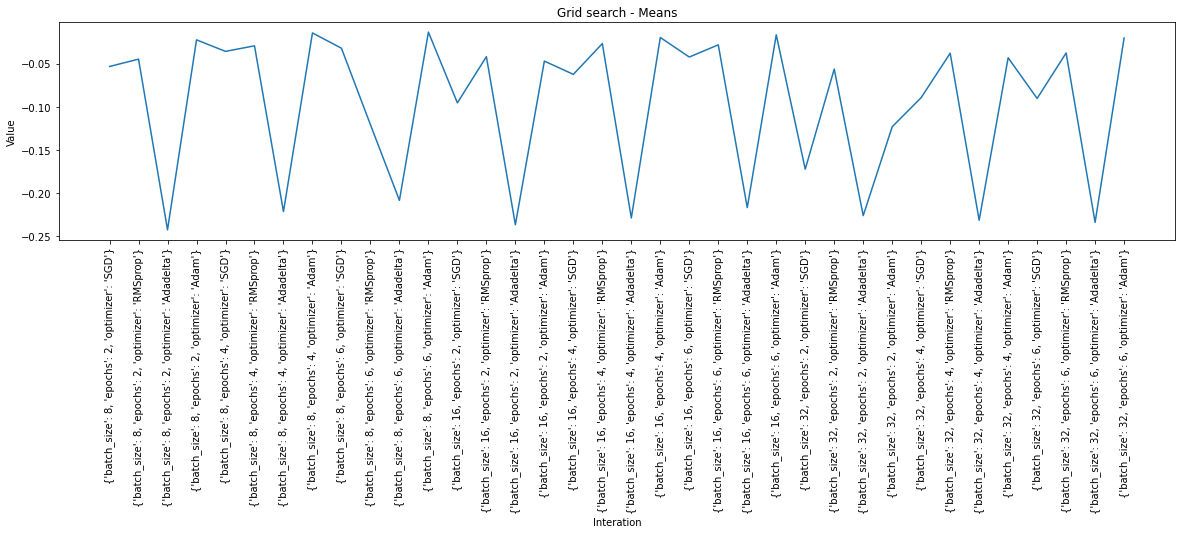

In [109]:
#plt.plot(params, means)
plt.plot(list_params, means)
plt.xticks(rotation=90)
plt.title('Grid search - Means') 
plt.ylabel('Value')
plt.xlabel('Interation')
plt.rcParams["figure.figsize"] = (4,20)
plt.show()

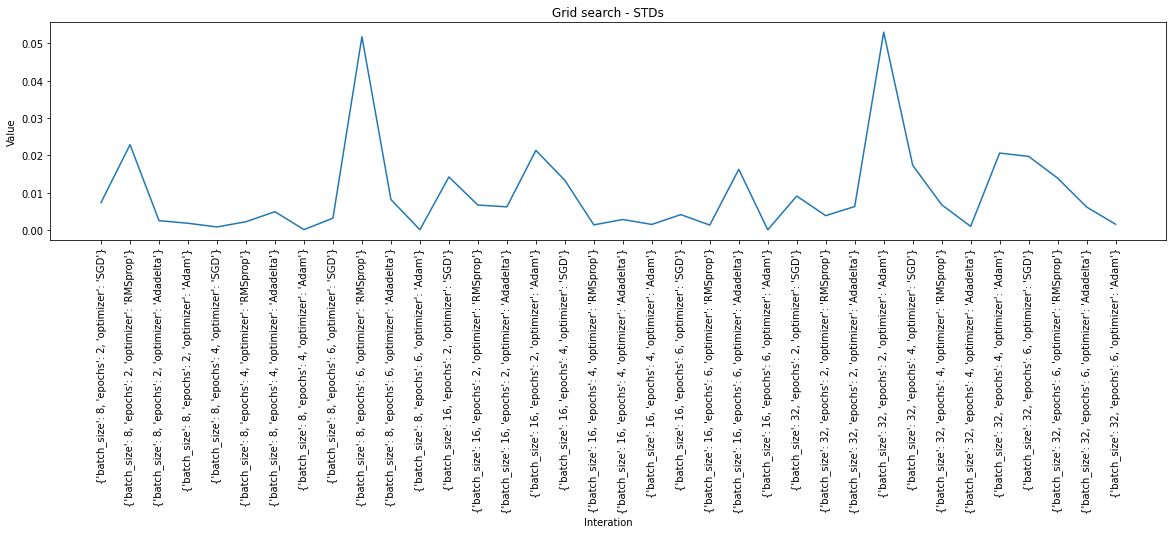

In [111]:
plt.plot(list_params, stds)
plt.xticks(rotation=90)
plt.title('Grid search - STDs') 
plt.ylabel('Value')
plt.xlabel('Interation')
plt.rcParams["figure.figsize"] = (4,20)
plt.show()

* 6.3 (b) Create RandomizedSearchCV()

In [90]:
# ก ําหนด Grid Search parameters
param_random_search = {'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam'],
                  'batch_size': list(np.linspace(8, 64, 5, dtype = int)),
                  'epochs': list(np.linspace(1, 10, 4, dtype = int))}

In [92]:
grid_rand = RandomizedSearchCV( estimator=model,
                                verbose= 0,
                                cv=2,
                                random_state = 10,
                                n_iter = 10, # จำนวน random parameters
                                param_distributions = param_random_search,)

In [93]:
grid_rand_result = grid_rand.fit(x_train_noisy, train_x)

In [94]:
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'optimizer': 'RMSprop', 'epochs': 7, 'batch_size': 36}
Best score:  -0.028433993458747864


In [95]:
means_rand = grid_rand_result.cv_results_['mean_test_score']
stds_rand = grid_rand_result.cv_results_['std_test_score']
params_rand = grid_rand_result.cv_results_['params']

In [99]:
# Display Statistics view
# Error results from All combinations of grid parameters -> plot() หรือ bar()



In [100]:
list_params_rand = []
for param in params_rand:
  list_params_rand.append(str(param))

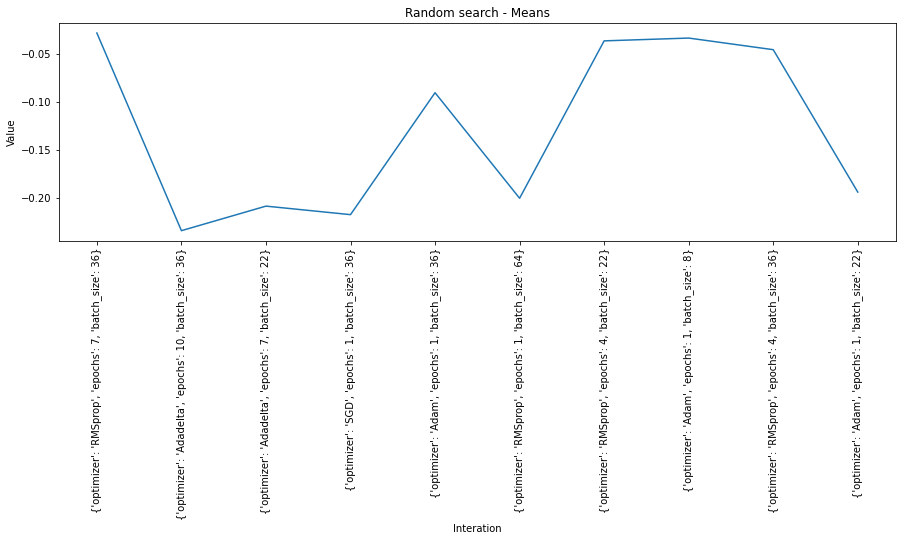

In [105]:

plt.plot(list_params_rand, means_rand)
plt.xticks(rotation=90)
plt.title('Random search - Means') 
plt.ylabel('Value')
plt.xlabel('Interation')
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

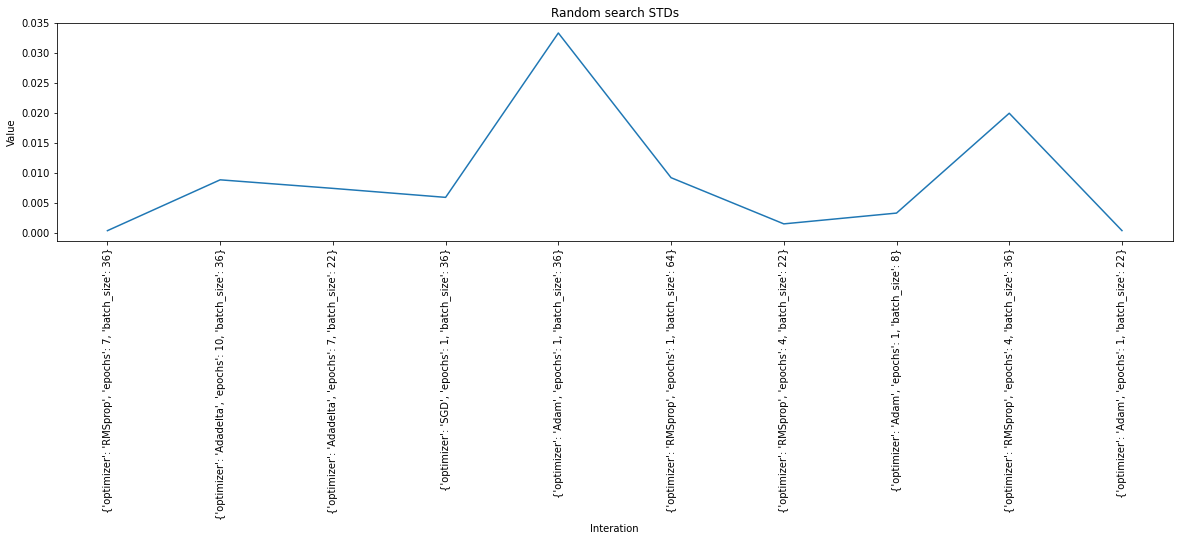

In [104]:
plt.plot(list_params_rand, stds_rand)
plt.xticks(rotation=90)
plt.title('Random search - STDs') 
plt.ylabel('Value')
plt.xlabel('Interation')
plt.rcParams["figure.figsize"] = (15,4)
plt.show()